In [1]:
pip install tensorflow scikit-learn numpy pandas matplotlib seaborn

In [2]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Veri setlerini yükleyelim
lap_times = pd.read_csv("lap_times.csv")
pit_stops = pd.read_csv("pit_stops.csv")
races = pd.read_csv("races.csv")
drivers = pd.read_csv("drivers.csv")


In [7]:
import pandas as pd

# Pit stop yapılan turlar için yeni bir DataFrame oluşturalım
pit_stops_subset = pit_stops[['raceId', 'driverId', 'lap']].copy()
pit_stops_subset['pit_stop'] = 1  # Pit stop yapılan turlara 1 ekleyelim

# `lap_times` ile `pit_stops` verisini birleştirelim (left join ile)
lap_times = lap_times.merge(pit_stops_subset, on=['raceId', 'driverId', 'lap'], how='left')

# NaN olanları 0 yapalım (Pit stop yapılmayan turlar için)
lap_times['pit_stop'] = lap_times['pit_stop'].fillna(0).astype(int)

# Değişiklikleri kontrol edelim
print(lap_times[['raceId', 'driverId', 'lap', 'pit_stop']].head(10))


   raceId  driverId  lap  pit_stop
0       1         1    1         0
1       1         1    2         0
2       1         1    3         0
3       1         1    4         0
4       1         1    5         0
5       1         1    6         0
6       1         1    7         0
7       1         1    8         0
8       1         1    9         0
9       1         1   10         0


In [8]:
print("Güncellenmiş lap_times sütunları:", lap_times.columns)


Güncellenmiş lap_times sütunları: Index(['raceId', 'driverId', 'lap', 'position', 'time', 'milliseconds',
       'milliseconds_scaled', 'pit_stop'],
      dtype='object')


In [10]:
# Zaman serisi sıralaması önemli
lap_times = lap_times.sort_values(by=['raceId', 'driverId', 'lap'])

# Min-Max Normalizasyonu
scaler = MinMaxScaler()
lap_times['milliseconds_scaled'] = scaler.fit_transform(lap_times[['milliseconds']])

# Kullanacağımız geçmiş tur sayısı (LSTM için pencere uzunluğu)
sequence_length = 5

# X ve Y veri setlerini oluştur
X, Y = [], []

# Her sürücü için ayrı zaman serisi pencereleri oluştur
for (race, driver), group in lap_times.groupby(['raceId', 'driverId']):
    lap_times_list = group['milliseconds_scaled'].values  # Normalleştirilmiş tur süreleri
    pit_stop_list = group['pit_stop'].values  # Pit stop yapılan turlar

    for i in range(len(lap_times_list) - sequence_length - 5):
        X.append(lap_times_list[i : i + sequence_length])
        Y.append(1 if 1 in pit_stop_list[i + sequence_length : i + sequence_length + 5] else 0)

# NumPy dizilerine çevir
X = np.array(X)
Y = np.array(Y)

# Eğitim ve test setlerine ayır
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# LSTM giriş verisini 3D formata getirelim (batch_size, time_steps, features)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

print("Eğitim veri boyutu:", X_train.shape, "Test veri boyutu:", X_test.shape)


Eğitim veri boyutu: (385025, 5, 1) Test veri boyutu: (96257, 5, 1)


In [12]:
# LSTM modelini tanımla
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, 1)),  # İlk LSTM katmanı
    Dropout(0.2),  # Overfitting'i önlemek için
    LSTM(32),  # İkinci LSTM katmanı
    Dropout(0.2),
    Dense(16, activation='relu'),  # Tam bağlı katman
    Dense(1, activation='sigmoid')  # Çıktı katmanı (Binary classification için sigmoid)
])

# Modeli derle
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Modeli eğit
history = model.fit(X_train, Y_train, epochs=10, batch_size=64, validation_data=(X_test, Y_test))

# Modeli kaydet
model.save("lstm_pitstop_model.h5")


Epoch 1/10
6017/6017 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.8986 - loss: 0.3360 - val_accuracy: 0.9003 - val_loss: 0.3252
Epoch 2/10
6017/6017 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - accuracy: 0.9005 - loss: 0.3243 - val_accuracy: 0.9003 - val_loss: 0.3239
Epoch 3/10
6017/6017 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - accuracy: 0.9011 - loss: 0.3219 - val_accuracy: 0.9003 - val_loss: 0.3220
Epoch 4/10
6017/6017 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - accuracy: 0.9000 - loss: 0.3220 - val_accuracy: 0.9003 - val_loss: 0.3203
Epoch 5/10
6017/6017 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - accuracy: 0.8997 - loss: 0.3222 - val_accuracy: 0.9003 - val_loss: 0.3201
Epoch 6/10
6017/6017 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - accuracy: 0.9005 - loss: 0.3204 - val_accuracy: 0.9003 - val_loss: 0.3200
Epoch 7/10
6017/6017 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - accuracy: 0.9004 - loss: 0.3205 - val_accuracy: 0.9003 - val_loss: 0.3196
Epoch 8/10
6017/6017 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - accuracy: 0.9005 - loss: 0

3009/3009 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9007 - loss: 0.3198
Test Doğruluğu: 0.9003


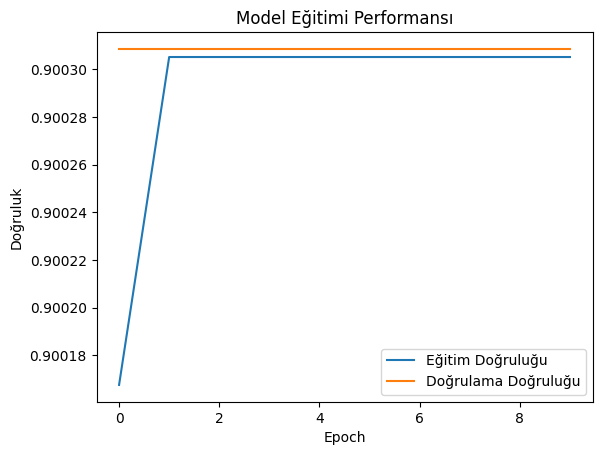

In [13]:
# Modeli değerlendir
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"Test Doğruluğu: {test_acc:.4f}")

# Eğitim sürecini görselleştir
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel("Epoch")
plt.ylabel("Doğruluk")
plt.legend()
plt.title("Model Eğitimi Performansı")
plt.show()


In [14]:
# Örnek bir sürücünün son 5 tur süresini kullanarak pit stop ihtimalini tahmin et
def predict_pit_stop(last_5_laps):
    last_5_laps = np.array(last_5_laps).reshape(1, sequence_length, 1)  # Modelin giriş boyutuna uygun hale getirme
    prob = model.predict(last_5_laps)[0][0]
    return f"Pit Stop Yapma Olasılığı: {prob:.2f}"

# Örnek veri
example_laps = X_test[0].flatten().tolist()  # Test setindeki bir sürücü verisi
print(predict_pit_stop(example_laps))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
Pit Stop Yapma Olasılığı: 0.07
